<a href="../projects.html">back to projects</a>

# PyTorch Basics

This is my personal cheasheet of PyTorch basics following this excellent tutorial:

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

If you wish to jump to the final code (like my future-self), click <a href="#summary">here</a>.

We'll learn about how a data analyst actually uses PyTorch through the simplest machine learning method, the linear regression
$$y = a + bx + \epsilon.$$

Let's work with a generated example.

For consistency, we'll fix the random seed as 42 throughout the example.

In [1]:
import numpy as np

# Data Generation
np.random.seed(42)
n = 100
x = np.random.rand(n, 1)
y = 1 + 2 * x + .1 * np.random.randn(n, 1)

# Shuffles the indices
idx = np.arange(n)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Text(0, 0.5, 'y')

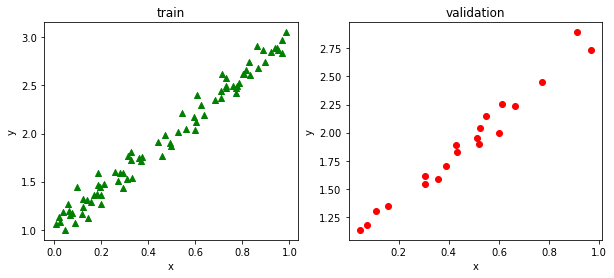

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.scatter(x_train, y_train, color='green', marker='^')
plt.title('train')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(x_val, y_val, color='red', marker='o')
plt.title('validation')
plt.xlabel('x')
plt.ylabel('y')

Now how does PyTorch estimate $a = 1$ and $b = 2$?

## Gradient Descent

### Compute the Loss

The loss here is given by the MSE.
- It is worth mentioning that, if we use all points in the training set (N) to compute the loss, we are performing a batch gradient descent. If we were to use a single point at each time, it would be a stochastic gradient descent. Anything else (n) in-between 1 and N characterizes a mini-batch gradient descent.



Time to import PyTorch and load my GPU.

When GPU is loaded and we gain an access to the video RAM, we'll transfer our current data (which is in the main RAM) to the video memory.

The numpy array data stored in RAM will be converted to tensors when they are transfered to the video memory.

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

import os
os.environ["PATH"] += os.pathsep + 'D:/ProgramData/Miniconda3/envs/pytorch/Library/bin/graphviz/'

if torch.cuda.is_available():
    device = 'cuda'
    print('cuda ready')
else:
    device = 'cpu'
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

cuda ready
<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In case we have to bring a tensor in the video RAM back to a numpy array in RAM, we need to pass through CPU.
```python
x_train_tensor.cpu().numpy()
```

Now we'll choose random numbers $a, b$ as an initial estimation.

Note that the parameters $a, b$ of the model are the variables that we'll take a partial derivative when it comes to apply gradient descent. In PyTorch, we need to state it clearly by adding `requires_grad=True`.

We also add `device=device` to make sure we use GPU computation.

In [4]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


Using `pytorchviz` (which is essentially `Graphviz`), we can visualize the dynamic computation happening during the backward propagation process.

For example, if `yhat` is a variable caculated by
```python
yhat = a + b * x_train + 0.1 * np.randn(1)
```
Then `make_dot(yhat)` will display a graph representing the backpropagation.

It's called a dynamic computing graph.

In [5]:
# what was this for?
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

## Model class

I guess it is customary to create a model class instead of manually coding all the loops for gradient computation and updating the parameters $(a, b)$.

I wish to leave a short remark on python modules.
- ClassName(nn.Module) means this class is inheriting the nn.Module class.
- Double underscore __ means the method will not be directly accessed.
    - Say we have an example instance `my_class = ClassName()`. Then you wouldn't use `myclass.__init__()`.
- `self` is also not that complicated to understand. It's just the empty input.
    - For example, if `ClassName` has a `function(self)` method, both `myclass.function()` or `ClassName.function(myclass)` to the same.
- `super()` refers to the parent class.

In [6]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

About `forward()` and `__call__`.
- `forward()` is part of `nn.Module.__call__()`.
- `my_class_instance()` is shorthand for `my_class_instance.__call__()`.
- Thus in practice, we use the forward function as `my_class_instance(input)`.

`x(arg1, arg2, ...)` is a shorthand for `x.__call__(arg1, arg2, ...)`.

In [7]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

# Choose a loss function and an optimizer from libraries
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    
    # Tell PyTorch that we'll use backpropagation
    # in computing the gradient of the loss function
    loss.backward()    
    
    # step() means updating the parameters (a, b) a sigle step toward the gradient.
    optimizer.step()
    
    # gradients are accumulative in PyTorch, we should reset it.
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='cuda:0')), ('b', tensor([0.1288], device='cuda:0'))])
OrderedDict([('a', tensor([1.0235], device='cuda:0')), ('b', tensor([1.9690], device='cuda:0'))])


## Nested Model

The custom model class defined in the previous example was an over-kill, as PyTorch offers a linear model.

In [8]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with
        # inpute features: 1
        # output features: 1
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [9]:
# Like the reference of a pointer
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([0.2018], requires_grad=True)]

## Sequential Model

Our example model was a simple **straightforward model**. One could design any straightforward model by using a sequential model module.

In [10]:
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

## Training Step

This is an extra customary to make the code look simpler.

Computing the loss and taking the step in each epoch could be integrated into a single function.

In [11]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters
        optimizer.step()
        # Zeroes gradients
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    # Returns THE FUNCTION that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
# An empty array to record the loss value per each epoch
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.4869]], device='cuda:0')), ('0.bias', tensor([0.5873], device='cuda:0'))])


## Dataset

So far, we've seen a custom model class and a step function.

Here we'll define a custom Dataset class.

Why Dataset class? The Dataset class will allow us cut the data in a convenient way so that we could apply mini-batch easier.
- We need Dataset + DataLoader to achieve this.

In [12]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        # These are pre-loaded data in the sense that
        # when we need the actual data in training,
        # we'll use the __getitem__ function defined below.
        self.x = x_tensor
        self.y = y_tensor
        
    # The __getitem__(i) loads the i'th data (on demand)
    # You usually don't load all the data at once when the data size is huge.
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    # Returns the size of the data.
    def __len__(self):
        return len(self.x)

# Prepare the input tensors to our Dataset.
# Wait, is this a CPU tensor now? Why? Where is .to(device)?
# This is a pre-load process of the data.
# We pre-load the whole data in RAM as CPU tensors,
# then send a piece by piece on demand to the video RAM
# using the __getitem__ function
# in order to save space in the video RAM.
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Using CustomDataset
train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])
print(train_data.__len__())

# Using TensorDataset when you just use a couple of tensors
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])
print(train_data.__len__())

(tensor([0.7713]), tensor([2.4745]))
80
(tensor([0.7713]), tensor([2.4745]))
80


## DataLoader

DataLoader prepares Dataset to be used in mini-batch (Cut and slice).

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

To see the whole slices of pieces,
```python
[*train_loader]
```

To see a sample piece for a single batch,
```python
next(iter(train_loader))
```

In [14]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.4869]], device='cuda:0')), ('0.bias', tensor([0.5873], device='cuda:0'))])


## Random Split

Going back to the beginning of pre-processing the data, `random_split` helps us to prepare the training set and the test (validation) set.

In [15]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [16]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    
    # Evaluation of our model at the end of each epoch
    # It is a good practice to wrap the validation with
    # the context manager torch.no_grad()
    # to disable gradient calculation.
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # Turn the evaluation mode on
            model.eval()

            # Make predictions
            yhat = model(x_val)
            
            # Compute the loss
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.4869]], device='cuda:0')), ('0.bias', tensor([0.5873], device='cuda:0'))])


<a name="summary"></a>
# Summary

cuda ready.
training and validation tensors ready.


<IPython.core.display.Javascript object>


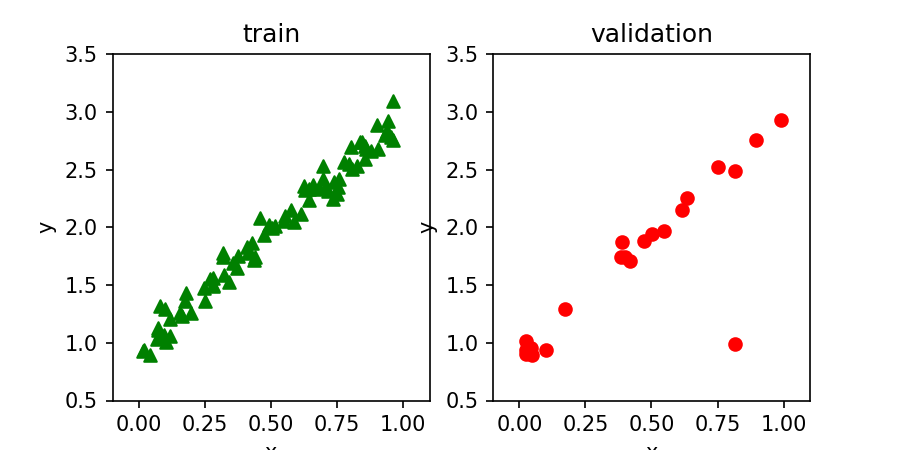

training and validation tensors ready for mini-batch.
model declared.
loss function declared.
optimizer declared.
training step function declared.
initiate training.
number of epochs:  1000
training complete
OrderedDict([('0.weight', tensor([[2.0107]], device='cuda:0')), ('0.bias', tensor([0.9490], device='cuda:0'))])


<IPython.core.display.Javascript object>


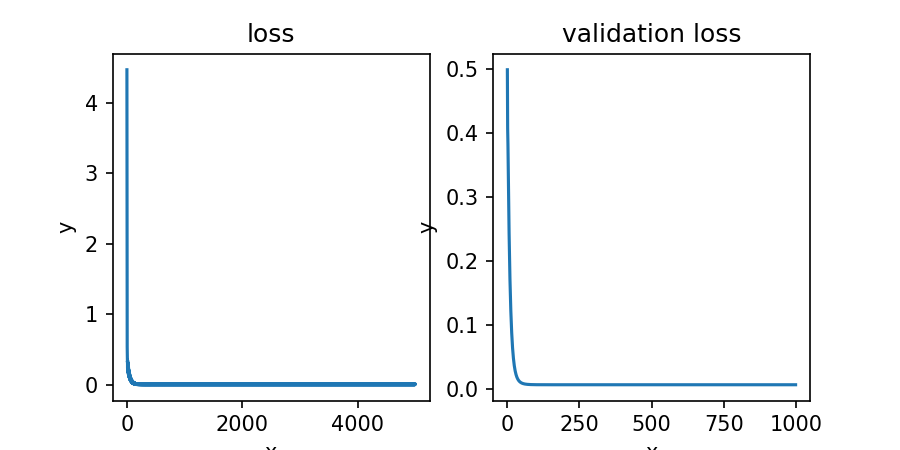

In [17]:
import numpy as np

# Data Generation
#np.random.seed(42)
n = 100
x = np.random.rand(n, 1)
y = 1 + 2 * x + .1 * (np.random.randn(n, 1) - 0.5)









# Load PyTorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchviz import make_dot

import os
os.environ["PATH"] += os.pathsep + 'D:/ProgramData/Miniconda3/envs/pytorch/Library/bin/graphviz/'

if torch.cuda.is_available():
    device = 'cuda'
    print('cuda ready.')
else:
    device = 'cpu'



    
    
    
    
    

    
    

# Training-test random split
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
dataset = TensorDataset(x_tensor, y_tensor)
train_dataset, val_dataset = random_split(dataset, [80, 20])
print('training and validation tensors ready.')















# Visualize data
%matplotlib notebook
import matplotlib.pyplot as plt
figsize = (6, 3)
plt.figure(figsize = figsize)

plt.subplot(121)
plt.scatter(np.array([*train_dataset])[:, 0], np.array([*train_dataset])[:, 1], color='green', marker='^')
plt.xlim(-0.1, 1.1)
plt.ylim(0.5, 3.5)
plt.title('train')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(val_dataset[0], val_dataset[1], color='red', marker='o')
plt.scatter(np.array([*val_dataset])[:, 0], np.array([*val_dataset])[:, 1], color='red', marker='o')
plt.xlim(-0.1, 1.1)
plt.ylim(0.5, 3.5)
plt.title('validation')
plt.xlabel('x')
plt.ylabel('y')

plt.show()













# DataLoader for mini-batch
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)
print('training and validation tensors ready for mini-batch.')





# Model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print('model declared.')







# Loss function
loss_fn = nn.MSELoss(reduction='mean')
print('loss function declared.')




# Optimizer and learning rate
lr = 1e-1
optimizer = optim.SGD(model.parameters(), lr=lr)
print('optimizer declared.')







# Training step
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters
        optimizer.step()
        # Zeroes gradients
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    # Returns THE FUNCTION that will be called inside the train loop
    return train_step
print('training step function declared.')






# Train
print('initiate training.')
losses = []
val_losses = []
estimated_parameters = []
train_step = make_train_step(model, loss_fn, optimizer)
n_epochs = 1000
print('number of epochs: ', n_epochs)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    
    # Evaluation of our model at the end of each epoch
    # It is a good practice to wrap the validation with
    # the context manager torch.no_grad()
    # to disable gradient calculation.
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # Turn the evaluation mode on
            model.eval()

            # Make predictions
            yhat = model(x_val)
            
            # Compute the loss
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    # can i record the parameters (a, b)?
    b = model.state_dict()['0.weight'].item()
    a = model.state_dict()['0.bias'].item()
    estimated_parameters.append([a, b])

print('training complete')
print(model.state_dict())









# Visualize loss
plt.figure(figsize = figsize)

plt.subplot(121)
plt.plot(losses)
plt.title('loss')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.plot(val_losses)
plt.title('validation loss')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

# Visualization

We finish this note with a visualization of the learning progress.

<IPython.core.display.Javascript object>


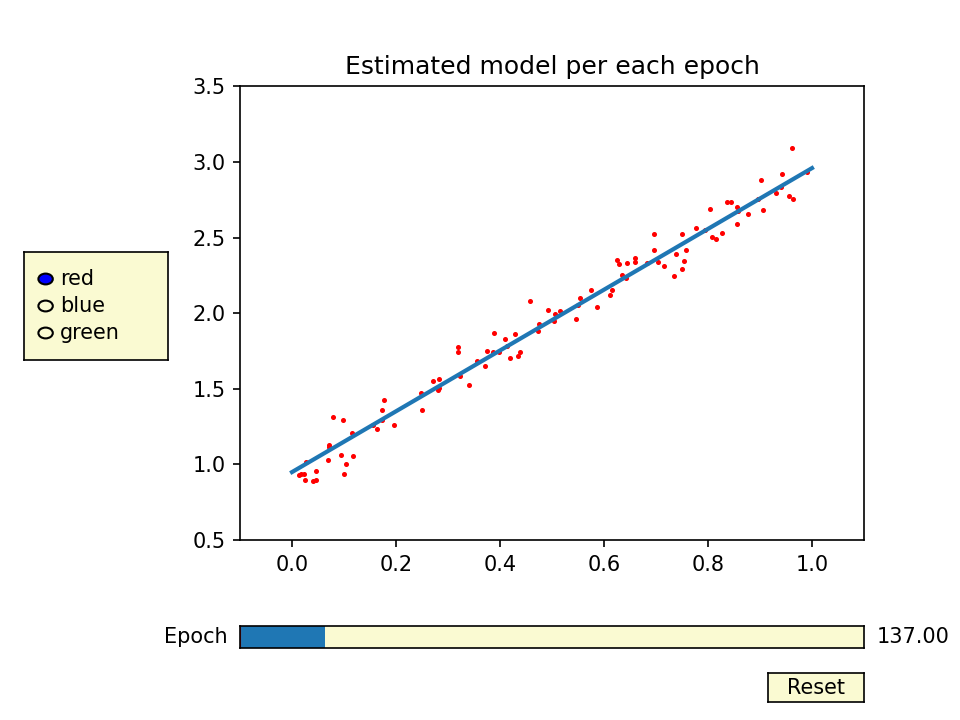

In [18]:
%matplotlib notebook

from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

# Generate data
t = np.arange(2)
i = 0
di = 1
a = np.array(estimated_parameters)[i, 0]
b = np.array(estimated_parameters)[i, 1]
f = a + b * t

# Actual plot. What's l,? Just (l)?
l, = plt.plot(t, f, lw=2)
plt.scatter(x, y, color='red', marker='o', s=2)
# Just fit the left end and the right end of the graph to the screen.
#ax.margins(x=0, y=1)
plt.xlim(-0.1, 1.1)
plt.ylim(0.5, 3.5)
plt.title('Estimated model per each epoch')

# Slider specs
axcolor = 'lightgoldenrodyellow'
ax_epoch = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)

# Slider set-up
s_epoch = Slider(ax_epoch, 'Epoch', 0, n_epochs, valinit=i, valstep=di)


def update(val):
    i = s_epoch.val
    a = np.array(estimated_parameters)[i, 0]
    b = np.array(estimated_parameters)[i, 1]
    l.set_ydata(a + b * t)
    fig.canvas.draw_idle()
    print(i)


s_epoch.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    s_epoch.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)



plt.show()

The source code can be found
<a href="notebook/pytorch_basics.ipynb">here</a>.

Last edited: 2020/9/22